In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
import calendar
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

 ### Data Exploration 

In [3]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 0:00:00,1,0,0,1,9.84,14.395,81.0,0.0,3,13,16
1,2011-01-01 1:00:00,1,0,0,1,9.02,13.635,80.0,0.0,8,32,40
2,2011-01-01 2:00:00,1,0,0,1,9.02,13.635,80.0,0.0,5,27,32
3,2011-01-01 3:00:00,1,0,0,1,9.84,14.395,75.0,0.0,3,10,13
4,2011-01-01 4:00:00,1,0,0,1,9.84,14.395,75.0,0.0,0,1,1


In [4]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered
0,2012-06-30 1:00:00,3,0,0,3,26.24,28.790,89.0,15.0013,3,55
1,2012-06-30 2:00:00,3,0,0,2,26.24,28.790,89.0,0.0000,7,54
2,2012-06-30 3:00:00,3,0,0,2,26.24,28.790,89.0,0.0000,3,20
3,2012-06-30 4:00:00,3,0,0,2,25.42,27.275,94.0,0.0000,3,15
4,2012-06-30 5:00:00,3,0,0,1,26.24,28.790,89.0,11.0014,3,7


In [5]:
train.shape, test.shape

((12980, 12), (4399, 11))

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12980 entries, 0 to 12979
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    12980 non-null  object 
 1   season      12980 non-null  int64  
 2   holiday     12980 non-null  int64  
 3   workingday  12980 non-null  int64  
 4   weather     12980 non-null  int64  
 5   temp        12980 non-null  float64
 6   atemp       12980 non-null  float64
 7   humidity    12980 non-null  float64
 8   windspeed   12980 non-null  float64
 9   casual      12980 non-null  int64  
 10  registered  12980 non-null  int64  
 11  count       12980 non-null  int64  
dtypes: float64(4), int64(7), object(1)
memory usage: 1.2+ MB


* We can infer that all of the variable in the dataset except datetime are numerical variables. Now Let's look at the distribution of our target variable, i.e. count. As it is a numerical variable, let us look at its distribution.

# Univariate Analysis 

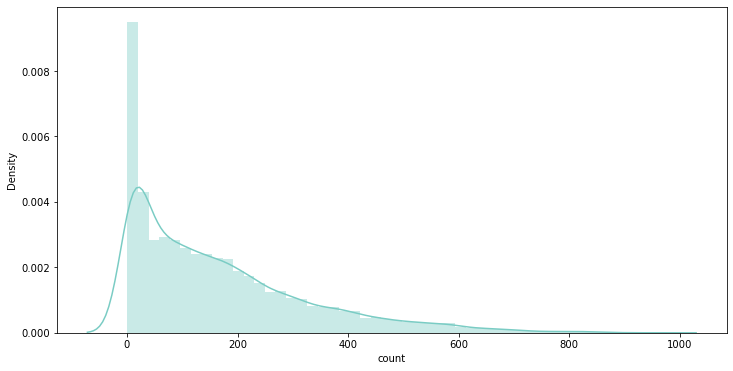

In [7]:
plt.figure(figsize = (12,6))
sns.set_palette('GnBu', 1)
sns.distplot(train['count'])
plt.show()

* We can clearly see that the distribution is skewed towards right and hence we can take log of the variable and see if the distribution becomes normal.

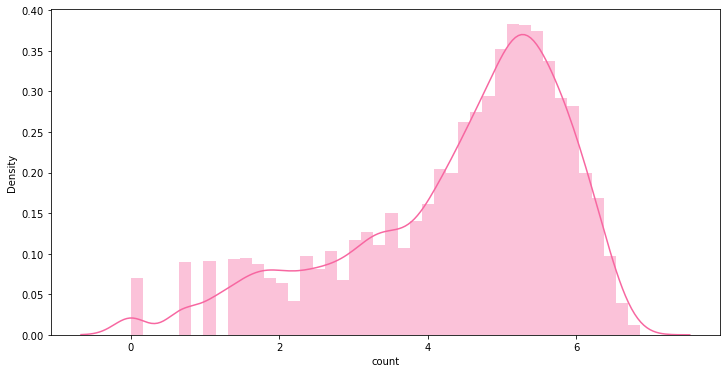

In [8]:
plt.figure(figsize = (12,6))
sns.set_palette('RdPu', 1)
sns.distplot(np.log(train['count']))
plt.show()

* Now the distribution looks less skewed.


 * Let's now explore the variables to have a better understanding of the dataset.
 * We will first explore the variables individually using univariate analysis, then we will look at the relation between various independent variables and the target variable. 
 * We will also look at the correlation plot to see which variables affects the target variable most.
 
 
 
 * Let's first look at the distribution of registered variable to check the number of registered user rentals initiated.

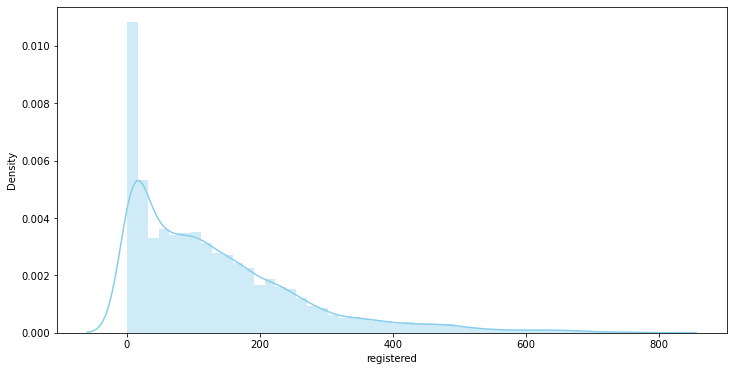

In [9]:
plt.figure(figsize = (12,6))
sns.distplot(train.registered, color = 'skyblue')
plt.show()

* We can see that most of the registered rentals lies in the range of 0 to 200. The registered users at a particular time step will always be less than or equal to the demand (count) of that particular timestep.




* Let's now look at how correlated our numerical variables are.




* We will see the correlation between each of these variables and the variable which have high negative or positive values are correlated. By this we can get an overview of the variables which might affect our target variable.

# Bivariate Analysis

<AxesSubplot:>

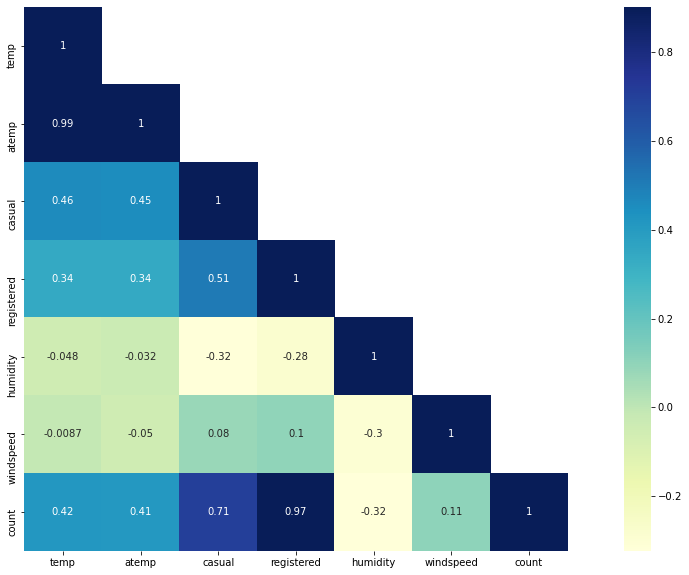

In [10]:
#corelation between all numerical variables :
corr = train[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig, ax= plt.subplots()
fig.set_size_inches(20, 10)
sns.heatmap(corr, mask = mask, vmax =.9, square = True, annot = True, cmap = "YlGnBu")

### Insights : 


 * temp and humidity features has got positive and negative correlation with count respectively.Although the correlation between them are not very prominent still the count variable has got little dependency on "temp" and "humidity".
 * windspeed will not be really useful numerical feature and it is visible from it correlation value with "count"
 * Since "atemp" and "temp" has got strong correlation with each other, during model building any one of the variable has to be dropped since they will exhibit multicollinearity in the data.

* Since there are no missing values in train and test datasets now we will move on to data modelling but before that we have to extract some new features from 'datetime' variable.
* We will extract date, hour & month.

In [11]:
train.isnull().sum(), test.isnull().sum()

(datetime      0
 season        0
 holiday       0
 workingday    0
 weather       0
 temp          0
 atemp         0
 humidity      0
 windspeed     0
 casual        0
 registered    0
 count         0
 dtype: int64,
 datetime      0
 season        0
 holiday       0
 workingday    0
 weather       0
 temp          0
 atemp         0
 humidity      0
 windspeed     0
 casual        0
 registered    0
 dtype: int64)

In [12]:
# extracting date, hour and month from the datetime
train["date"] = train.datetime.apply(lambda x : x.split()[0])
train["hour"] = train.datetime.apply(lambda x : x.split()[1].split(":")[0])
train["month"] = train.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,month
0,2011-01-01 0:00:00,1,0,0,1,9.84,14.395,81.0,0.0,3,13,16,2011-01-01,0,1
1,2011-01-01 1:00:00,1,0,0,1,9.02,13.635,80.0,0.0,8,32,40,2011-01-01,1,1
2,2011-01-01 2:00:00,1,0,0,1,9.02,13.635,80.0,0.0,5,27,32,2011-01-01,2,1
3,2011-01-01 3:00:00,1,0,0,1,9.84,14.395,75.0,0.0,3,10,13,2011-01-01,3,1
4,2011-01-01 4:00:00,1,0,0,1,9.84,14.395,75.0,0.0,0,1,1,2011-01-01,4,1


* Making similar changes with test dataset as it also have a datetime variable.

In [13]:
test['date'] = train.datetime.apply(lambda x : x.split()[0])
test['hour'] = train.datetime.apply(lambda x : x.split()[1].split(':')[0])
test['month'] = train.date.apply(lambda dateString : datetime.strptime(dateString, '%Y-%m-%d').month)
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,date,hour,month
0,2012-06-30 1:00:00,3,0,0,3,26.24,28.790,89.0,15.0013,3,55,2011-01-01,0,1
1,2012-06-30 2:00:00,3,0,0,2,26.24,28.790,89.0,0.0000,7,54,2011-01-01,1,1
2,2012-06-30 3:00:00,3,0,0,2,26.24,28.790,89.0,0.0000,3,20,2011-01-01,2,1
3,2012-06-30 4:00:00,3,0,0,2,25.42,27.275,94.0,0.0000,3,15,2011-01-01,3,1
4,2012-06-30 5:00:00,3,0,0,1,26.24,28.790,89.0,11.0014,3,7,2011-01-01,4,1


### NOTE :

 
 * Now our data is ready. 
 * Before making a model we will make validation set to validate our model. For that we will devide our train dataset into two parts such as training dataset and validation dataset.
 * We will train our model on training dataset and check its performance on validation dataset.
 * Since the data is time based, we will split it as per time. we'll take first 15 months for training and remaining 3 months in the validation set.

In [14]:
training = train[train['datetime']<='2012-03-30 0:00:00']
validation = train[train['datetime']>'2012-03-30 0:00:00']

In [15]:
#training.shape, validation.shape

* We will drop the datetime, date variable as we have already extracted features from these variables.
* We will also drop the atemp variable as we saw that it is highly correlated with the temp variable.

In [16]:
train = train.drop(['datetime','date', 'atemp'],axis=1)
test = test.drop(['datetime','date', 'atemp'], axis=1)
training = training.drop(['datetime','date', 'atemp'],axis=1)
validation = validation.drop(['datetime','date', 'atemp'],axis=1)

# Model building

## Linear Regression Model

In [17]:
from sklearn.linear_model import LinearRegression
lModel = LinearRegression()

* We will remove the target variable from both the training and validation set and keep it in a separate variable. 
* We saw in the visualization part that the target variable is right skewed, so we will take its log as well before feeding it to the model.

In [18]:
X_train = training.drop('count', 1)
y_train = np.log(training['count'])
X_val = validation.drop('count', 1)
y_val = np.log(validation['count'])

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((10774, 11), (10774,), (2206, 11), (2206,))

### NOTE
 * Now we have a trained linear regression model with us. We will now make prediction on the x_val set and check the performance of our model. Since the evaluation metric for this problem is RMSLE, we will define a model which will return the RMSLE score.

* Fitting the model on x_train and y_train

In [19]:
lModel.fit(X_train,y_train)

LinearRegression()

* Making prediction on validation set

In [21]:
prediction = lModel.predict(X_val)

# RMSLE



 * Defining a function which will return RMSLE score

In [25]:
def rmsle(y, y_):
    y = np.exp(y),   # taking the exponential as we took the log of target variable
    y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

* Now calculate the rmsle value of the predictions

In [26]:
rmsle(y_val,prediction)

0.8875379204281793

In [ ]:
#test_prediction = lModel.predict(test)

### NOTE
 * We got a rmsle value of 0.8875 on the validation set.
 * We'll use Decision Tree now. Note that rmsle tells us how far the predictions are from the actual value, so we want rmsle value to be as close to 0 as possible. So, we will further try to reduce this value.

# Decision Tree

In [27]:
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(max_depth = 5)

*  Fit the decision tree model now.

In [29]:
dt_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5)

* Now we'll make prediction on the validation set using the trained decision tree model.

In [30]:
predict = dt_reg.predict(X_val)

In [31]:
# calculating rmsle of the predicted values
rmsle(y_val, predict)

0.1710226739944696

* The rmsle value has decreased to 0.171. This is a decent score.
* Now make predictions for the test dataset which you can submit in the excel sheet provided to generate score.

In [32]:
test_pred = dt_reg.predict(test)

* These are the log values and we have to convert them back to the original scale.

In [33]:
final_pred = np.exp(test_pred)

In [34]:
test_pred.shape

(4399,)

* Finally, we will save these predictions into a csv file. 
* Open this csv file and copy paste the predictions on the provided excel file to generate score.

In [35]:
submission = pd.DataFrame()

In [37]:
submission['count'] = final_pred

In [38]:
submission.to_csv('submission.csv', header=True, index=False)

In [39]:
ef = pd.read_csv('submission.csv')
ef.head()

,count
0,67.337495
1,67.337495
2,22.218489
3,14.518412
4,8.652763
